In [1]:
import random
import pickle
from collections import Counter

import scanpy as sc
import numpy as np
import pandas as pd

import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scover

# SEACells
import SEACells

mpl.rcParams['figure.figsize'] = (6, 4)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


In [2]:
random.seed(1612)
np.random.seed(1612)

%matplotlib inline

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = [4,4]

# Pooling with SEACells

In this notebook, I show the workflow to create a dataset for Scover with the [recently published SEACells method](https://www.nature.com/articles/s41587-023-01716-9). Note: this is experimental, we have <u>_not_</u> yet tried to run the model on this data. This is adapted from the [jupyter notebook](https://github.com/dpeerlab/SEACells/blob/main/notebooks/SEACell_computation.ipynb) from the SEACells github.

In [3]:
ad = sc.read("data/Marrow.h5ad")

In [4]:
ad.raw = ad

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


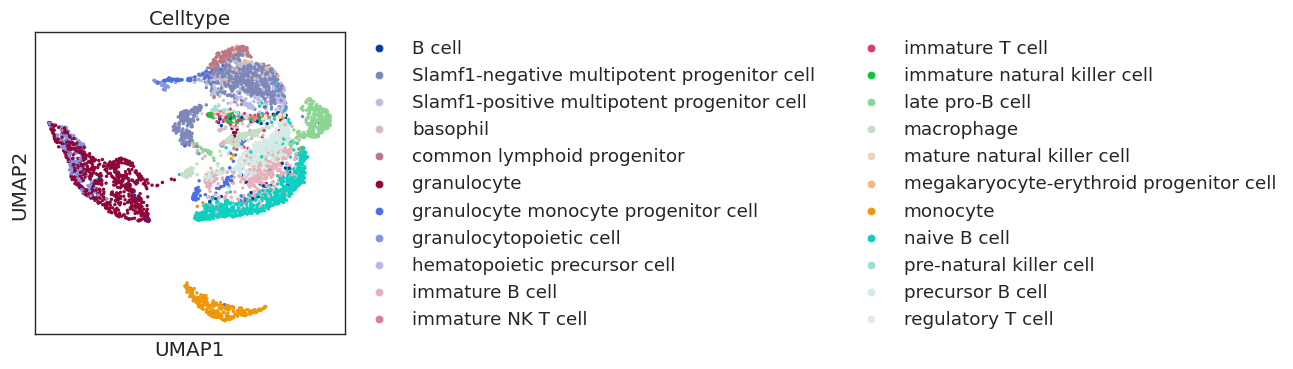

In [5]:
sc.pl.umap(ad, color='Celltype')

## Setting up and running SEACells

In [6]:
# We want around one SEACell for every 75 cells.
ad.shape[0] // 75

67

In [7]:
n_SEACells = 70 # A nice round number close to 67
build_kernel_on = 'X_pca'
n_waypoint_eigs = 10

In [8]:
model = SEACells.core.SEACells(ad, 
                               build_kernel_on=build_kernel_on, 
                               n_SEACells=n_SEACells, 
                               n_waypoint_eigs=n_waypoint_eigs,
                               convergence_epsilon = 1e-5)

Welcome to SEACells!


In [9]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...


/nfs/team218/jh47/miniconda3/envs/sc/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/team218/jh47/miniconda3/envs/sc/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/team218/jh47/miniconda3/envs/sc/lib/python3.9/site-packages/uma

Computing radius for adaptive bandwidth kernel...


  0%|          | 0/5037 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/5037 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/5037 [00:00<?, ?it/s]

Constructing CSR matrix...


In [10]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 58 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|███████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 247.81it/s]

Selecting 12 cells from greedy initialization.


In [11]:
model.fit(min_iter=7, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00121
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Starting iteration 40.
Completed iteration 40.
Converged after 41 iterations.


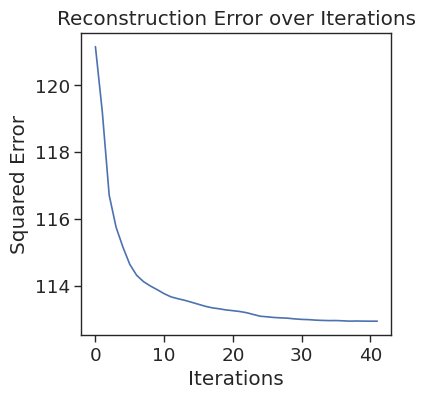

In [12]:
# Check for convergence 
model.plot_convergence()

In [13]:
print(f'Ran for {len(model.RSS_iters)} iterations')

Ran for 42 iterations


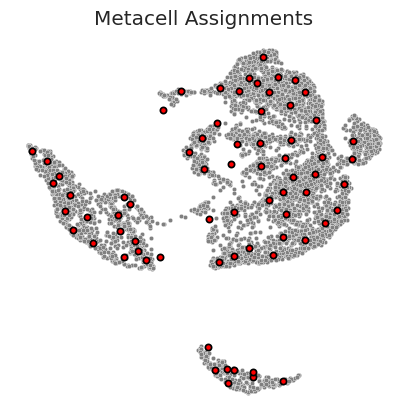

In [14]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=False)

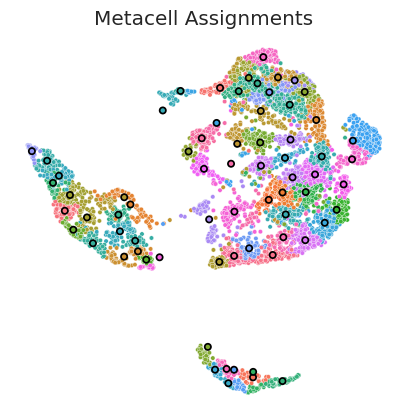

In [15]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)

/nfs/team218/jh47/miniconda3/envs/sc/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


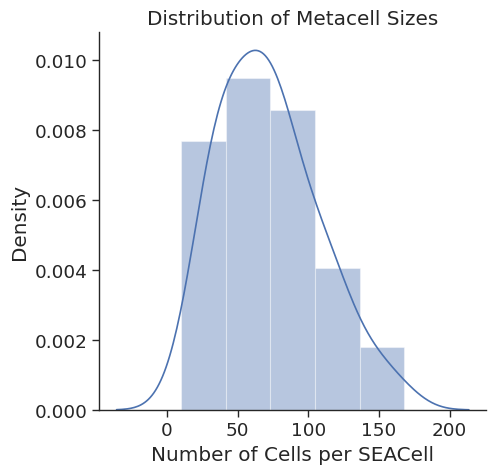

,size
SEACell,
SEACell-0,90
SEACell-1,64
SEACell-10,54
SEACell-11,34
SEACell-12,59
...,...
SEACell-68,35
SEACell-69,61
SEACell-7,52


In [16]:
SEACells.plot.plot_SEACell_sizes(ad, bins=5)

In [17]:
# SEACells hard assignments
ad.obs[['SEACell']].head()

,SEACell
index,
A22.D042044.3_9_M.1.1,SEACell-43
C5.D042044.3_9_M.1.1,SEACell-51
D10.D042044.3_9_M.1.1,SEACell-31
E13.D042044.3_9_M.1.1,SEACell-6
F19.D042044.3_9_M.1.1,SEACell-51


## Pool cells using SEACells hard assignments

In [18]:
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='raw')
SEACell_ad

100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 112.62it/s]


AnnData object with n_obs × n_vars = 70 × 23433
    layers: 'raw'

## Assess cell type purity

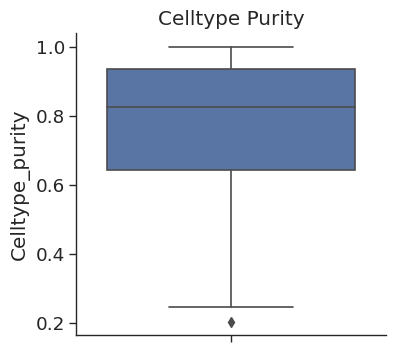

,Celltype,Celltype_purity
SEACell,,
SEACell-0,naive B cell,0.866667
SEACell-1,granulocyte,0.640625
SEACell-10,granulocyte monocyte progenitor cell,0.388889
SEACell-11,monocyte,0.970588
SEACell-12,precursor B cell,0.830508


In [19]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(ad, 'Celltype')

plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='Celltype_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

## Add cell type annotation

In [20]:
SEACell_ad.obs['most_abundant_celltype'] = SEACell_purity.loc[SEACell_ad.obs.index]['Celltype']
SEACell_ad.obs['Celltype_purity'] = SEACell_purity.loc[SEACell_ad.obs.index]['Celltype_purity']

## Turn sparse matrix into regular matrix

In [21]:
SEACell_ad.X = SEACell_ad.X.toarray()

## Normalize

Since the pools formed by SEACells can contain varying amounts of cells, it is necessary to normalise each cell:

In [22]:
sc.pp.normalize_total(SEACell_ad)

## Assess sparsity before and after pooling

In [23]:
sp_b = (ad.X.toarray() == 0).sum() / ad.shape[0] / ad.shape[1]
sp_a = (SEACell_ad.X == 0).sum() / SEACell_ad.shape[0] / SEACell_ad.shape[1]
print(f"Sparsity before: {round(sp_b*100, 2)}%")
print(f"Sparsity after:  {round(sp_a*100, 2)}%")

Sparsity before: 86.49%
Sparsity after:  47.1%


## Save dataset by uncommenting the following

In [24]:
# SEACell_ad.write("data/Marrow_pooled_SEACells.h5ad")
# ad.obs[['SEACell']].to_csv('data/Marrow_pooled_SEACells_hard_assignments.csv')

## Now, you can follow the regular workflow for adding the sequences and running Scover

(See the other notebooks)

## (Optional:) visualise dataset

In [25]:
sc.pp.log1p(SEACell_ad)

In [26]:
sc.tl.pca(SEACell_ad)
sc.pp.neighbors(SEACell_ad)
sc.tl.umap(SEACell_ad)

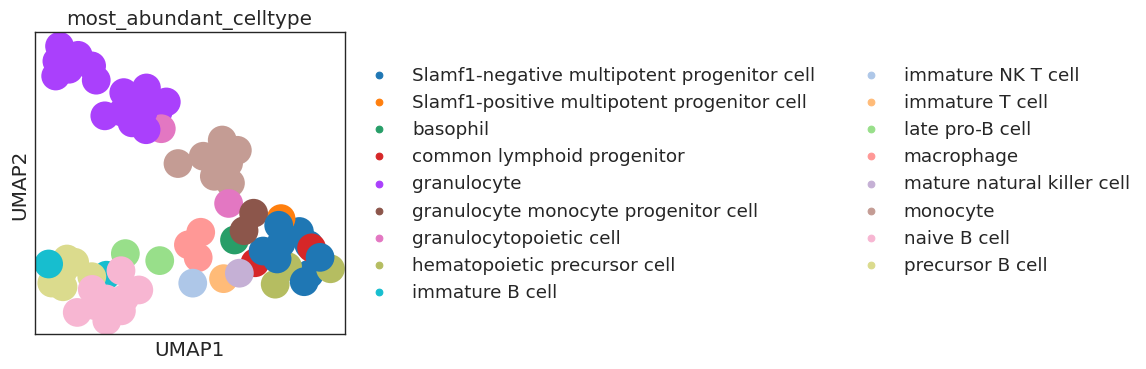

In [27]:
sc.pl.umap(SEACell_ad, color='most_abundant_celltype')

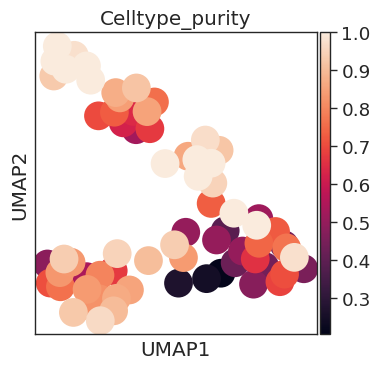

In [28]:
sc.pl.umap(SEACell_ad, color='Celltype_purity')